In [212]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.models import model_from_yaml
from keras.callbacks import TensorBoard

import pandas as pd
import numpy as np
import json
import os

import common
from importlib import reload
%matplotlib inline


In [232]:
reload(common)

(train_sentences, train_categories, test_sentences, test_categories) = common.load_dataset('../dataset/redis_dataset.csv', split=0.8)
print(train_sentences.shape)

9849
(7879,)


In [276]:
#
# Parameters
#
max_features = 6000
maxlen = 160
batch_size = 128
embedding_dims = 100
filters = 100
kernel_size = 3
hidden_dims = 100
epochs = 10


In [277]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index

print('Found %s unique tokens.' % len(dictionary))

# Let's save this out so we can use it later
with open('models/dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)


Found 5398 unique tokens.


In [278]:
#
# Load Glove embeddings
#
glove_dir = '/Users/nscsekhar/Desktop/nscsekhar/Desktop/Surya/Personal/MIDS/W266/glove/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

#
# Get Embedding matrix
#
embedding_matrix = np.zeros((max_features, embedding_dims))
for word, i in dictionary.items():
    if i < max_features:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [279]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = sequence.pad_sequences(test_sequences, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
# print(train_sequences[:10])

Pad sequences (samples x time)
x_train shape: (7879, 160)
x_test shape: (1970, 160)


In [280]:
model = Sequential()

model.add(Embedding(max_features,
                    embedding_dims,
#                     weights=[embedding_matrix],
#                     trainable=False,
                    input_length=maxlen))
model.add(Dropout(0.1))


In [281]:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

In [282]:
model.add(GlobalMaxPooling1D())

In [283]:
model.add(Dense(hidden_dims))
model.add(Dropout(0.1))
model.add(Activation('relu'))

In [284]:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 160, 100)          600000    
_________________________________________________________________
dropout_36 (Dropout)         (None, 160, 100)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 158, 100)          30100     
_________________________________________________________________
global_max_pooling1d_23 (Glo (None, 100)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_37 (Dropout)         (None, 100)               0         
_________________________________________________________________
activation_44 (Activation)   (None, 100)               0         
__________

In [285]:
reload(common)

tbCallback = TensorBoard(log_dir='./logs/cnn', histogram_freq=0,
                          write_graph=True, write_images=False)

metrics = common.Metrics()

history = model.fit(x_train, train_categories,
          batch_size=batch_size,
          epochs=10,
          validation_data=(x_test, test_categories), 
          callbacks=[metrics, tbCallback])


Train on 7879 samples, validate on 1970 samples
Epoch 1/10
7879/7879 [==============================] - 10s 1ms/step - loss: 0.6225 - acc: 0.6582 - val_loss: 0.5487 - val_acc: 0.7183
Epoch 2/10
7879/7879 [==============================] - 11s 1ms/step - loss: 0.4509 - acc: 0.7860 - val_loss: 0.4469 - val_acc: 0.7777
Epoch 3/10
7879/7879 [==============================] - 10s 1ms/step - loss: 0.3421 - acc: 0.8474 - val_loss: 0.4328 - val_acc: 0.7858
Epoch 4/10
7879/7879 [==============================] - 11s 1ms/step - loss: 0.2565 - acc: 0.8922 - val_loss: 0.4621 - val_acc: 0.7787
Epoch 5/10
7879/7879 [==============================] - 11s 1ms/step - loss: 0.1746 - acc: 0.9322 - val_loss: 0.4850 - val_acc: 0.7909
Epoch 6/10
7879/7879 [==============================] - 11s 1ms/step - loss: 0.1166 - acc: 0.9581 - val_loss: 0.5487 - val_acc: 0.7893
Epoch 7/10
7879/7879 [==============================] - 11s 1ms/step - loss: 0.0711 - acc: 0.9789 - val_loss: 0.6097 - val_acc: 0.7914
Epoch 8

In [286]:
reload(common)
metrics.print_all()

Precision: 0.7276478679504814
Recall: 0.815068493150685
F1: 0.744970798182998


In [297]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))
from keras.utils import plot_model

plot_model(model, show_shapes=True, to_file='model.png')

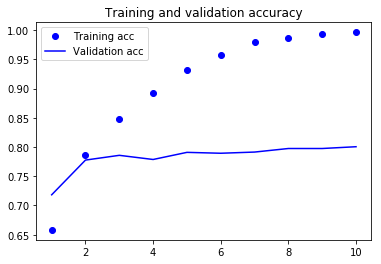

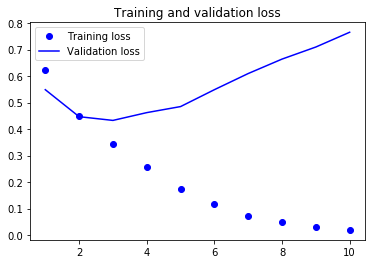

In [288]:
reload(common)
common.plot_model_history(history)

In [289]:
#
# Save the model as a yaml
#
model_yaml = model.to_yaml()
with open("models/cnn_model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("models/cnn_model.h5")
print("Saved model to disk")


Saved model to disk


In [290]:
# load YAML and create model
yaml_file = open("models/cnn_model.yaml", 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()

loaded_model = model_from_yaml(loaded_model_yaml)

# load weights into new model
loaded_model.load_weights("models/cnn_model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, test_categories, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 80.05%


In [291]:
#
# Load a new source file
#
# reload(common)
test_file='/tmp/fe-connect.c'
comment_sents = []

#
# Get comment sentences
#
comment_sents += common.get_comment_sents(test_file)
# print(len(comment_sents))
# for sent in comment_sents:
#     print(sent)


In [293]:
#
# Predict the comment sentences
#
reload(common)
pred_tokenizer = Tokenizer(num_words=6000)
labels = ['Needs Fix', 'Good comment']

with open('models/dictionary.json', 'r') as dictionary_file:
    dictionary = json.load(dictionary_file)

for sent in comment_sents:
    print("Sentence: \n",sent)
    comment_sequence = common.convert_text_to_index_array(sent, dictionary)
    comment_vector = sequence.pad_sequences([comment_sequence], maxlen=maxlen)

    pred = loaded_model.predict_classes(comment_vector)
    print("Readability score: ", labels[int(pred)])

    #print("%s sentiment; %f%% confidence" % (labels[np.argmax(pred)], pred[0][np.argmax(pred)] * 100))
    

Sentence: 
  mstcpip.h is missing on mingw
Readability score:  Needs Fix
Sentence: 
  OpenLDAP deprecates RFC 1823, but we want standard conformance
Readability score:  Needs Fix
Sentence: 
   Pre-9.0 servers will return this SQLSTATE if asked to set  application_name in a startup packet.
Readability score:  Needs Fix
Sentence: 
 We hard-wire the value rather  than looking into errcodes.h since it reflects historical behavior  rather than that of the current code.
Readability score:  Good comment
Sentence: 
  This is part of the protocol so just define it
Readability score:  Needs Fix
Sentence: 
  This too
Readability score:  Needs Fix
Sentence: 
   Cope with the various platform-specific ways to spell TCP keepalive socket  options.
Readability score:  Good comment
Sentence: 
 This doesn't cover Windows, which as usual does its own thing.
Readability score:  Good comment
Sentence: 
  TCP_KEEPIDLE is the name of this option on Linux and BSD
Readability score:  Needs Fix
Sentence: 
  TCP

   PQsetdbLogin   establishes a connection to a postgres backend through the postmaster  at the specified host and port.
Readability score:  Needs Fix
Sentence: 
 returns a PGconn which is needed for all subsequent libpq calls   if the status field of the connection returned is CONNECTION_BAD,  then only the errorMessage is likely to be useful.
Readability score:  Good comment
Sentence: 
   Allocate memory for the conn structure
Readability score:  Good comment
Sentence: 
   If the dbName parameter contains what looks like a connection string,  parse it into conn struct using connectOptions1.
Readability score:  Needs Fix
Sentence: 
   Old-style path: first, parse an empty conninfo string in order to  set up the same defaults that PQconnectdb() would use.
Readability score:  Good comment
Sentence: 
  Insert dbName parameter value into struct
Readability score:  Good comment
Sentence: 
   Insert remaining parameters into struct, overriding defaults (as well  as any conflicting data from

Readability score:  Good comment
Sentence: 
  Handle error from a pre-3.0 server
Readability score:  Needs Fix
Sentence: 
  reread data
Readability score:  Needs Fix
Sentence: 
  We'll come back when there is more data
Readability score:  Good comment
Sentence: 
  OK, we read the message; mark data consumed
Readability score:  Needs Fix
Sentence: 
   The postmaster typically won't end its message with a  newline, so add one to conform to libpq conventions.
Readability score:  Good comment
Sentence: 
   If we tried to open the connection in 3.0 protocol,  fall back to 2.0 protocol.
Readability score:  Needs Fix
Sentence: 
  Must drop the old connection
Readability score:  Good comment
Sentence: 
   Can't process if message body isn't all here yet.
Readability score:  Needs Fix
Sentence: 
 (In protocol 2.0 case, we are assuming messages carry at  least 4 bytes of data.)
Readability score:  Good comment
Sentence: 
   Before returning, try to enlarge the input buffer if  needed to hold the

Readability score:  Good comment
Sentence: 
 On failure, an error message is stored in errbuf, which must be of size  errbufsize (recommended size is 256 bytes).
Readability score:  Needs Fix
Sentence: 
 errbuf is not changed on  success return.
Readability score:  Good comment
Sentence: 
   PQrequestCancel: old, not thread-safe function for requesting query cancel   Returns true if able to send the cancel request, false if not.
Readability score:  Good comment
Sentence: 
 On failure, the error message is saved in conn->errorMessage; this means  that this can't be used when there might be other active operations on  the connection object.
Readability score:  Good comment
Sentence: 
 NOTE: error messages will be cut off at the current size of the  error message buffer, since we dare not try to expand conn->errorMessage!
Readability score:  Good comment
Sentence: 
  Check we have an open connection
Readability score:  Needs Fix
Sentence: 
   pqPacketSend()  convenience routine to send a 

Readability score:  Needs Fix
Sentence: 
  Skip the URI prefix
Readability score:  Needs Fix
Sentence: 
  Should never happen
Readability score:  Needs Fix
Sentence: 
  Look ahead for possible user credentials designator
Readability score:  Good comment
Sentence: 
   Found username or password designator, so URI should be of the form  "scheme: or  or user[:password]@[netloc]".
Readability score:  Needs Fix
Sentence: 
  Save last char and cut off at end of user name
Readability score:  Needs Fix
Sentence: 
  Advance past end of parsed user name or password token
Readability score:  Needs Fix
Sentence: 
   No username or password designator found.
Readability score:  Needs Fix
Sentence: 
 Reset to start of URI.
Readability score:  Needs Fix
Sentence: 
   There may be multiple netloc[:port] pairs, each separated from the next  by a comma.
Readability score:  Good comment
Sentence: 
 When we initially enter this loop, "p" has been  incremented past optional URI credential information at th